# Classifying insect eggs

Created by B. de Medeiros starting on 29-jan-2018, as part of lesson 1 of fast.ai [course](https://course.fast.ai/index.html) Practical Deep Learning for Coders v3, part 1

Here we will use resnet to classify insect eggs based on their images (some are photographs, some are line drawings).
The original data comes from:

A database of egg size and shape from more than 6,700 insect species
Samuel H. Church, Seth Donoughe, Bruno A. S. de Medeiros, Cassandra G. Extavour
bioRxiv 471953; doi: https://doi.org/10.1101/471953

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Downloading data

In the paper, Church et al cropped images of eggs from their original publications to create a visualization tool, available on github. To check out the interactive tool, see: https://shchurch.github.io/dataviz/index.html

The github repository of the visualization tool contains small images in png format and a csv table with information on each image. In this document, we want to test if we can train a model to recognize the [order](https://en.wikipedia.org/wiki/Order_(biology)) of an insect based on an image of its eggs.

Let's start by cloning the repo:

In [1]:
!git clone https://github.com/shchurch/insect_egg_database_viz.git

Cloning into 'insect_egg_database_viz'...
remote: Enumerating objects: 5123, done.
remote: Counting objects: 100% (5123/5123), done.
remote: Compressing objects: 100% (5071/5071), done.
remote: Total 5123 (delta 54), reused 5107 (delta 42), pack-reused 0
Receiving objects: 100% (5123/5123), 1.16 GiB | 46.92 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (5018/5018), done.


Now let's start to work in Python. We will import the packages we will need first:

In [52]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path

Now let's use pandas to read the table with image data:

In [107]:
egg_data = pd.read_table('./insect_egg_database_viz/data/dataviz_egg_database.csv')
egg_data.head()

,ID,bibtex,bib_author,year,family,superfamily,subfamily,suborder,order,tribe,...,X3,logX1,logX2,logX3,ar,el,vol,logar,logvol,group
0,17,Hernandez-Mejia2013a,"Hernández-Mejía, Blanca Claudia and Flores-Gal...",2013,Pieridae,Papilionoidea,Pierinae,Glossata,Lepidoptera,Pierini,...,NaN,0.232818,-0.229443,NaN,2.899084,1.899084,0.311123,0.462261,-0.507068,Amphiesmenoptera
1,18,Hernandez-Mejia2013a,"Hernández-Mejía, Blanca Claudia and Flores-Gal...",2013,Pieridae,Papilionoidea,Pierinae,Glossata,Lepidoptera,Pierini,...,NaN,0.191199,-0.228045,NaN,2.625697,1.625697,0.284517,0.419245,-0.545892,Amphiesmenoptera
2,19,Hernandez-Mejia2013a,"Hernández-Mejía, Blanca Claudia and Flores-Gal...",2013,Pieridae,Papilionoidea,Pierinae,Glossata,Lepidoptera,Pierini,...,NaN,0.183867,-0.246187,NaN,2.691874,1.691874,0.257331,0.430055,-0.589508,Amphiesmenoptera
3,20,Hernandez-Mejia2013a,"Hernández-Mejía, Blanca Claudia and Flores-Gal...",2013,Pieridae,Papilionoidea,Pierinae,Glossata,Lepidoptera,Pierini,...,NaN,0.399847,-0.107238,NaN,3.214286,2.214286,0.802361,0.507084,-0.095630,Amphiesmenoptera
4,21,Peterson1968,"Peterson, Alvah",1968,Geometridae,Geometroidea,Geometrinae,Glossata,Lepidoptera,NaN,...,0.25,-0.187087,-0.397940,-0.60206,1.625000,0.625000,0.034034,0.210853,-1.468088,Amphiesmenoptera


Now let's keep only the column with order and that with IDs, which will be used to retrieve file names.

In [108]:
egg_data = egg_data[['ID','order']]
egg_data.head()

,ID,order
0,17,Lepidoptera
1,18,Lepidoptera
2,19,Lepidoptera
3,20,Lepidoptera
4,21,Lepidoptera


Finally, let's create a column with file paths from ID names:

In [109]:
egg_data['name'] = 'ID' + egg_data.ID.astype('str') + '.png' 
egg_data = egg_data.drop('ID',axis=1)
egg_data.head()

,order,name
0,Lepidoptera,ID17.png
1,Lepidoptera,ID18.png
2,Lepidoptera,ID19.png
3,Lepidoptera,ID20.png
4,Lepidoptera,ID21.png


In [110]:
egg_data = egg_data.rename({'order':'label'},axis=1)
egg_data = egg_data[['name','label']]
egg_data.head()

,name,label
0,ID17.png,Lepidoptera
1,ID18.png,Lepidoptera
2,ID19.png,Lepidoptera
3,ID20.png,Lepidoptera
4,ID21.png,Lepidoptera


Now we have all the data we need!

## Training the model

Let's start by training a resnet34, as seen in class. We will use a batch size of 64:

In [111]:
bs = 64

Now let's set the path to files:

In [112]:
path = Path('insect_egg_database_viz/pics/Entry_PNGs_cropped')
path

PosixPath('insect_egg_database_viz/pics/Entry_PNGs_cropped')

In [119]:
path.ls()[:5]

[PosixPath('insect_egg_database_viz/pics/Entry_PNGs_cropped/ID10003.png'),
 PosixPath('insect_egg_database_viz/pics/Entry_PNGs_cropped/ID9814.png'),
 PosixPath('insect_egg_database_viz/pics/Entry_PNGs_cropped/ID4060.png'),
 PosixPath('insect_egg_database_viz/pics/Entry_PNGs_cropped/ID6100.png'),
 PosixPath('insect_egg_database_viz/pics/Entry_PNGs_cropped/ID4884.png')]

Now we have to filter the dataframe only to images that exist in the path:

In [135]:
egg_data = egg_data.merge(pd.DataFrame({'name':[p.name for p in path.ls()]}), on= 'name', how = 'inner')

And now, create the image bunch object and check it:

In [136]:
data = ImageDataBunch.from_df(path, egg_data, ds_tfms=get_transforms(), size=120)

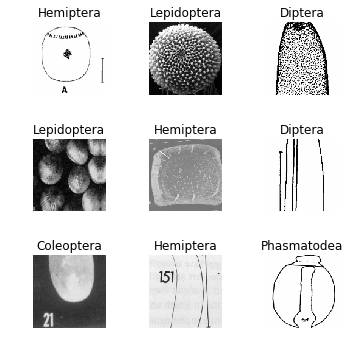

In [138]:
data.show_batch(rows=3, figsize=(5,5))

In [140]:
data.classes

['Archaeognatha',
 'Blattodea',
 'Coleoptera',
 'Collembola',
 'Dermaptera',
 'Diplura',
 'Diptera',
 'Embioptera',
 'Ephemeroptera',
 'Grylloblattodea',
 'Hemiptera',
 'Hymenoptera',
 'Lepidoptera',
 'Mantodea',
 'Mantophasmatodea',
 'Mecoptera',
 'Megaloptera',
 'Neuroptera',
 'Odonata',
 'Orthoptera',
 'Phasmatodea',
 'Phthiraptera',
 'Plecoptera',
 'Protura',
 'Psocoptera',
 'Raphidioptera',
 'Siphonaptera',
 'Strepsiptera',
 'Thysanoptera',
 'Trichoptera',
 'Zoraptera',
 'Zygentoma']

Now let's fit the model

In [142]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [143]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,2.958490,1.778122,0.448759
2,1.988521,1.363999,0.384035
3,1.524378,1.256010,0.357066
4,1.312288,1.197373,0.352751
5,1.181067,1.191969,0.350593


Not very good... Let's try unfreezing, as the class example

In [144]:
learn.save('egg-stage-1')

Let's start by finding the learning rate:

In [145]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


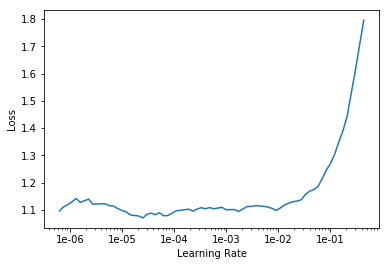

In [146]:
learn.recorder.plot()

Let's use learning rates from 1e-06 to te-02:

In [147]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,1.359190,1.288007,0.363538
2,1.119658,1.093159,0.309601


Better, let's run for another 5 epochs to see how good we can get:

In [149]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.890984,1.032265,0.291262
2,0.962585,1.168290,0.327940
3,0.854239,1.029626,0.282632
4,0.662976,1.014905,0.259978
5,0.503482,0.993093,0.251348


In [150]:
learn.save('egg-resnet34-unfreeze')

Much better! what if we use resner 50?

In [151]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


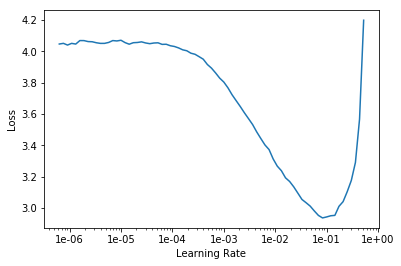

In [152]:
learn.lr_find()
learn.recorder.plot()

In [153]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate
1,2.750874,1.818144,0.445523
2,1.947996,1.373427,0.361381
3,1.505388,1.284693,0.358145
4,1.270893,1.119793,0.320388
5,1.113176,1.073230,0.304207
6,0.972535,1.055903,0.299892
7,0.889506,1.006018,0.280475
8,0.789997,1.020307,0.285868
9,0.707169,0.994882,0.269687
10,0.676923,0.995174,0.269687


Already better than resnet34. Let's now unfreeze and se if it improves:

In [154]:
learn.save('eggs-stage-1-50')

In [157]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.211749,1.008078,0.221143
2,0.260240,1.236297,0.244876
3,0.387348,1.548517,0.294498
4,0.425351,1.416861,0.278317
5,0.367487,1.375892,0.276160
6,0.297417,1.370438,0.261057
7,0.218156,1.234455,0.224380
8,0.161709,1.223296,0.226537
9,0.108568,1.242964,0.233010
10,0.091663,1.213650,0.221143


Wow, already much better! Let's now diagnose what is going wrong.

In [158]:
learn.save('eggs-stage-2-50')
interp = ClassificationInterpretation.from_learner(learn)

In [159]:
interp.most_confused(min_val=2)

[('Hymenoptera', 'Hemiptera', 10),
 ('Hemiptera', 'Hymenoptera', 9),
 ('Hemiptera', 'Lepidoptera', 8),
 ('Coleoptera', 'Hemiptera', 6),
 ('Diptera', 'Coleoptera', 6),
 ('Hemiptera', 'Coleoptera', 6),
 ('Hymenoptera', 'Coleoptera', 6),
 ('Lepidoptera', 'Coleoptera', 6),
 ('Hemiptera', 'Diptera', 5),
 ('Hymenoptera', 'Diptera', 5),
 ('Hymenoptera', 'Lepidoptera', 5),
 ('Orthoptera', 'Hemiptera', 5),
 ('Phasmatodea', 'Hemiptera', 5),
 ('Coleoptera', 'Diptera', 4),
 ('Diptera', 'Hemiptera', 4),
 ('Lepidoptera', 'Hemiptera', 4),
 ('Phasmatodea', 'Coleoptera', 4),
 ('Plecoptera', 'Hemiptera', 4),
 ('Coleoptera', 'Lepidoptera', 3),
 ('Ephemeroptera', 'Diptera', 3),
 ('Plecoptera', 'Lepidoptera', 3),
 ('Psocoptera', 'Lepidoptera', 3)]

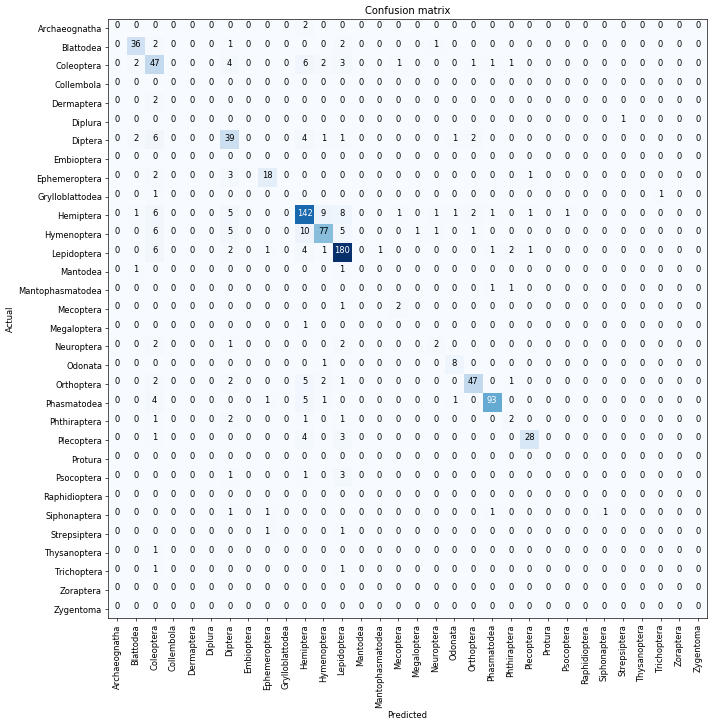

In [160]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

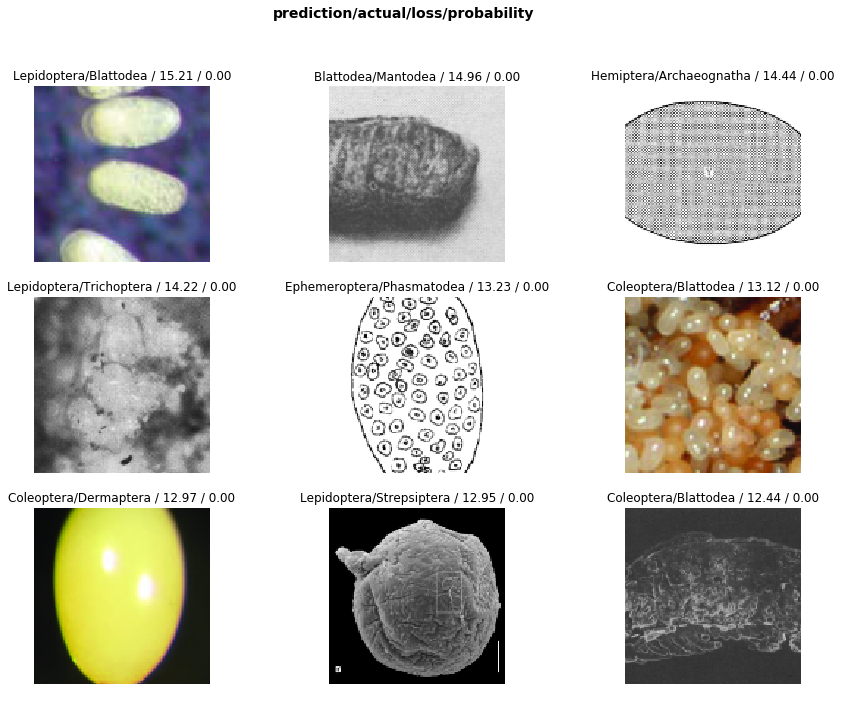

In [161]:
interp.plot_top_losses(9, figsize=(15,11))

## Filtered data

We can see that there were not many photos for a lot of orders. What if we filter the data only to orders with >=10 photos?

In [166]:
large_datasets = egg_data.label.value_counts()[egg_data.label.value_counts() > 10].index

In [167]:
egg_data_reduced = egg_data[egg_data.label.isin(large_datasets)]

In [169]:
data = ImageDataBunch.from_df(path, egg_data_reduced, ds_tfms=get_transforms(), size=120)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


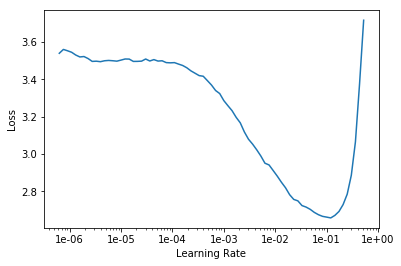

In [172]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

In [173]:
learn.fit_one_cycle(5)
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate
1,2.183987,1.364834,0.368593
2,1.594478,1.147423,0.344602
3,1.276401,1.010059,0.304253
4,1.060395,0.973148,0.303162
5,0.920535,0.954266,0.294438


epoch,train_loss,valid_loss,error_rate
1,0.905966,0.962467,0.282443
2,1.027050,1.018456,0.285714
3,0.995251,0.985164,0.275900
4,0.858783,0.976088,0.271538
5,0.690522,0.917094,0.241003
6,0.542193,0.924223,0.237732
7,0.398270,0.905540,0.215921
8,0.295930,0.913137,0.220284
9,0.231526,0.919061,0.209378
10,0.186520,0.915529,0.210469


In [174]:
learn.save('eggs_reduced-stage-2-50')
interp = ClassificationInterpretation.from_learner(learn)

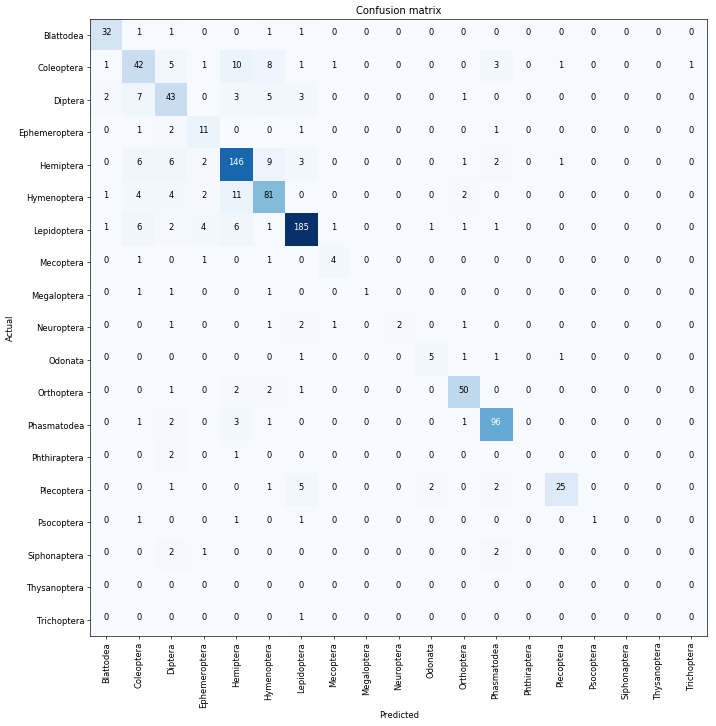

In [175]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

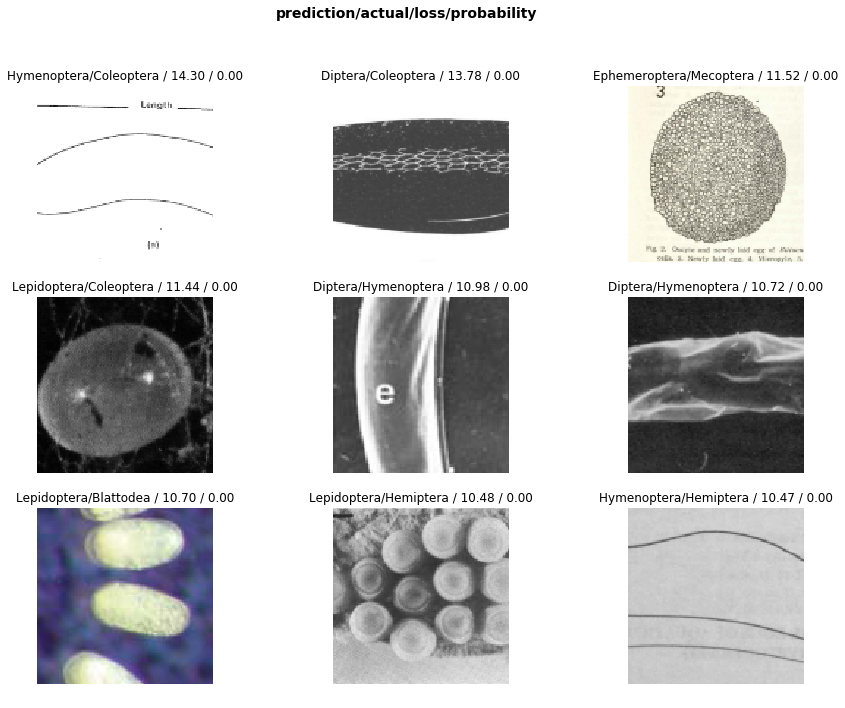

In [180]:
interp.plot_top_losses(9, figsize=(15,11))

These seem legitimate errors. For example: beetles have round eggs, like some moths and butterflies (Lepidoptera/Coleoptera); both some bugs and some moths and butterflies lay eggs in clusters (Lepidoptera/Hemiptera). Not bad at all for a first approach to the problem, especially considering the really unbalanced collection of kinds of image per order. I am actually surprised it ca

I am sure it could be improved. Let's learn more stuff in the other lessons and see what we can do.